In [1]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
import imageio #这个东西是用来读取tiff图片得
import seaborn as sns
import time   #时间相关的

plt.style.use('classic')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
path = os.path.abspath(os.path.dirname(os.getcwd()) + os.path.sep + ".")
raw_data_point = path+'\LSM\PointData'     #这个是用来读取点数据路径得
raw_data_raster = path+'\LSM\RasterData2'   #这个是用来读取像素数据得
Picture_result = path+'\LSM\Picture'   #这个是用来读取像素数据得


#本处为载入将要运用的全部模型
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import LinearSVC

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.metrics import accuracy_score,mean_squared_error,roc_auc_score,roc_curve

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 随机种子42     5折训练
SEED = 42 
NFOLDS = 5
KF = KFold(n_splits= NFOLDS,shuffle=True,random_state=SEED)

In [3]:
All_data = pd.read_csv('Raster10m.csv',encoding='utf-8',delimiter=',')
print('Raw shape of Px1 is',len(All_data))
print('(Po1) No HLS samples:',All_data['A0'].value_counts()[0],'HLS samples:',All_data['A0'].value_counts()[1])
print('(Po1) No ELS samples:',All_data['A1'].value_counts()[0],'ELS samples:',All_data['A1'].value_counts()[1])
print("-------------------------------------------------------")

PointReadtarget = ['\Point1.txt','\Point2.txt','\Point3.txt']
PointDataName = ['All_dataPo1','All_dataPo2','All_dataPo3']

for i,name in enumerate(PointDataName):
    globals()[name] = pd.read_csv(raw_data_point+PointReadtarget[i],encoding='ascii',delimiter=',')
    globals()[name].replace(-9999,np.nan,inplace=True)
    old_length = len(globals()[name])
    globals()[name].dropna(axis=0, how='any', inplace=True)
    new_length = len(globals()[name])
    print('Raw shape of Dataset',name,'is',old_length,'New:',new_length,'delete',old_length-new_length,'rows')
    globals()[name].replace({'A0': 1, 'A1': 1}, 0,inplace=True)
    globals()[name].replace({'A0': 2, 'A1': 2}, 1,inplace=True) 
    print(name,': No HLS samples:',globals()[name]['A0'].value_counts()[0],'HLS samples:',globals()[name]['A0'].value_counts()[1])
    print(name,': No HLS samples:',globals()[name]['A1'].value_counts()[0],'HLS samples:',globals()[name]['A1'].value_counts()[1])
    print("-------------------------------------------------------")


Raw shape of Px1 is 11130632
(Po1) No HLS samples: 10450944 HLS samples: 679688
(Po1) No ELS samples: 10765038 ELS samples: 365594
-------------------------------------------------------
Raw shape of Dataset All_dataPo1 is 500000 New: 493441 delete 6559 rows
All_dataPo1 : No HLS samples: 463089 HLS samples: 30352
All_dataPo1 : No HLS samples: 477032 HLS samples: 16409
-------------------------------------------------------
Raw shape of Dataset All_dataPo2 is 121534 New: 120561 delete 973 rows
All_dataPo2 : No HLS samples: 82922 HLS samples: 37639
All_dataPo2 : No HLS samples: 98779 HLS samples: 21782
-------------------------------------------------------
Raw shape of Dataset All_dataPo3 is 16162 New: 16042 delete 120 rows
All_dataPo3 : No HLS samples: 14006 HLS samples: 2036
All_dataPo3 : No HLS samples: 9868 HLS samples: 6174
-------------------------------------------------------


In [4]:
# 用来减少内存使用的方程
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum()  / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))  
    for col in df.columns:
        col_type = df[col].dtype    
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum()  / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
All_data = reduce_mem_usage(All_data)

Memory usage of dataframe is 1868.24 MB
Memory usage after optimization is: 435.22 MB
Decreased by 76.7%


## Minimum and maximum process (0.1-0.9)

In [9]:
LSM_Y =['A0']
LSM_X = ['A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12']
ESM_Y = ['A1']
ESM_X = ['A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A13','A14','A15','A16','A17','A18','A19','A20']

y_hls =  All_data[LSM_Y] ; y_hlsp1 = All_dataPo1[LSM_Y] ; y_hlsp2 = All_dataPo2[LSM_Y] ; y_hlsp3 = All_dataPo3[LSM_Y]
x_hls =  All_data[LSM_X] ; x_hlsp1 = All_dataPo1[LSM_X] ; x_hlsp2 = All_dataPo2[LSM_X] ; x_hlsp3 = All_dataPo3[LSM_X]
y_els =  All_data[ESM_Y] ; y_elsp1 = All_dataPo1[ESM_Y] ; y_elsp2 = All_dataPo2[ESM_Y] ; y_elsp3 = All_dataPo3[ESM_Y]
x_els =  All_data[ESM_X] ; x_elsp1 = All_dataPo1[ESM_X] ; x_elsp2 = All_dataPo2[ESM_X] ; x_elsp3 = All_dataPo3[ESM_X]

In [10]:
# 对输入模型进行标准化转化
from sklearn.preprocessing import StandardScaler,MinMaxScaler
print("-----------------------before the preprocessing--------------------------------")
Max_Sca = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_hls).data_max_
print('The maximun of each columns',Max_Sca)
Min_Sca = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_hls).data_min_
print('The minimun of each columns',Min_Sca)


print("-----------------------After the preprocessing--------------------------------")
column_index = x_hls.columns
x_hls_values = MinMaxScaler(feature_range=(0.1,0.9)).fit_transform(x_hls.values)
x_hls =pd.DataFrame(x_hls_values, columns = column_index) 


Max_Sca_after = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_hls).data_max_
print('The maximun of each columns',Max_Sca_after)
Min_Sca_after = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_hls).data_min_
print('The minimun of each columns',Min_Sca_after)

print("-----------------------preprocessing  Pointdata--------------------------------")

for i, column_name in enumerate(LSM_X):
    x_hlsp1[column_name] = x_hlsp1[column_name].apply(lambda X: 0.1 + 0.8*(X - Min_Sca[i])/(Max_Sca[i]-Min_Sca[i]))
    x_hlsp2[column_name] = x_hlsp2[column_name].apply(lambda X: 0.1 + 0.8*(X - Min_Sca[i])/(Max_Sca[i]-Min_Sca[i]))
    x_hlsp3[column_name] = x_hlsp3[column_name].apply(lambda X: 0.1 + 0.8*(X - Min_Sca[i])/(Max_Sca[i]-Min_Sca[i]))
    print('Factor :',column_name,'Finished')

-----------------------before the preprocessing--------------------------------
The maximun of each columns [   20.     17.     12.   1002.5    72.2   360.     54.2 10730.   9000.
  1885.   1308. ]
The minimun of each columns [ 1.000e+00  1.000e+00  1.000e+00  0.000e+00  0.000e+00 -1.000e+00
 -6.438e+01  0.000e+00  0.000e+00  0.000e+00  1.066e+03]
-----------------------After the preprocessing--------------------------------
The maximun of each columns [0.9    0.8994 0.8994 0.9    0.9    0.9    0.8994 0.9    0.9    0.9
 0.9004]
The minimun of each columns [0.1    0.1    0.1    0.1    0.1    0.1    0.1001 0.1    0.1    0.1
 0.0996]
-----------------------preprocessing  Pointdata--------------------------------
Factor : A2 Finished
Factor : A3 Finished
Factor : A4 Finished
Factor : A5 Finished
Factor : A6 Finished
Factor : A7 Finished
Factor : A8 Finished
Factor : A9 Finished
Factor : A10 Finished
Factor : A11 Finished
Factor : A12 Finished


In [62]:
initial_params ={'LR_HLS_params':{'penalty':'l2',
                                  'random_state':SEED,
                                  'verbose':0},
                 
                 'DT_HLS_params':{'criterion':'gini',
                                 'splitter':'best',
                                 'random_state':SEED},
                                
                 
                 'KNN_HLS_params':{'weights':'uniform',
                                   'algorithm':'auto'},
                 
                 'ANN_HLS_params':{'solver':'adam',
                                   'learning_rate':'adaptive',
                                   'max_iter':2000,
                                   'batch_size':200,
                                   'early_stopping':True},
                 
                 'MLP_HLS_params': {'solver':'adam',
                                    'learning_rate':'adaptive',
                                    'activation':'logistic',
                                    'max_iter':2000,
                                    'batch_size':200,
                                    'early_stopping':True},
                 
                 'RF_HLS_params':  {'criterion':'gini',
                                    'random_state':SEED}
                 }


In [63]:
LR_HLS_tuningparas = [
                     {'solver': ['newton-cg','sag','lbfgs'], 'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]},  #LR1
#                     {'tol':[1e-1,3e-1,1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5],'max_iter':[100,300,1000,3000,10000]} #LR2
                      ]


DT_HLS_tuningparas = [
                      {'max_depth': [3,4,5,6,7,8,9,10,20,30,50], 'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}, #DT1
                      {'min_samples_split':[2,3,4,5,6,7,8,9,10,20,30]}                                                    #DT2
                      ]


KNN_HLS_tuningparas = [
                      {'n_neighbors': [5,10,15,20,25,30,100], 'metric':['minkowski','euclidean','manhattan']}  #KNN1
                      ]

ANN_HLS_tuningparas = [
                      {'activation': ['identity', 'logistic', 'tanh', 'relu'],
                       'hidden_layer_sizes':[(16,),(32,),(64,),(128,),(256,),(512,)]}                         #ANN1
                      ]

MLP_HLS_tuningparas = [
                      {'hidden_layer_sizes':[(128,64),(128,64,32),(128,64,32,16),(128,64,32,16,8)]}           #MLP1
                      ]

RF_HLS_tuningparas =  [
                      {'max_depth': [3,4,5,6,7,8,9,10,20,'None'],'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]},  #RF1
                      {'min_samples_split':[2,3,4,5,6,7,8,9,10,20,30], 'n_estimators':[100,200,300,400,500]}               #RF2
                      ]

In [69]:
def get_models_tuning(initial_params):
    LR_HLS = LogisticRegression(**initial_params['LR_HLS_params'])
    DT_HLS = DecisionTreeClassifier(**initial_params['DT_HLS_params'])
    KNN_HLS = KNeighborsClassifier(**initial_params['KNN_HLS_params'])
    ANN_HLS = MLPClassifier(**initial_params['ANN_HLS_params'])
    MLP_HLS = MLPClassifier(**initial_params['MLP_HLS_params'])
    RF_HLS = RandomForestClassifier(**initial_params['RF_HLS_params'])
    
    
    tuning_models = {'LR_HLS': LR_HLS,
                     'DT_HLS': DT_HLS,
                     'KNN_HLS': KNN_HLS,
                     'ANN_HLS': ANN_HLS,
                     'MLP_HLS': MLP_HLS,
                     'RF_HLS': RF_HLS}
    
    
    
    return tuning_models

In [65]:
tuning_result = []

tuning_models = get_models_tuning(initial_params)
for m in tuning_models:
    print('==========================================',m,'===============================================') 
    df_cv_result=[]
    Temp_turning = locals()[m+'_tuningparas']
    for tuning_time in range(len(Temp_turning)):
        print('------------------------Finding Parameters,',m,tuning_time,'----------------------------') 
        print('Parameters:',Temp_turning[tuning_time])
        
        gsearch = GridSearchCV(estimator = tuning_models[m], 
                               param_grid = Temp_turning[tuning_time], scoring='roc_auc',cv=5, n_jobs=9, verbose=0)
        
        print('Start Fiting') 
        %time gsearch.fit(x_hlsp2,y_hlsp2)
        
        print(gsearch.best_params_,'Best evaluation Scores',gsearch.best_score_)
        initial_params[m+'_params'].update(gsearch.best_params_)
        print('Now The parameter becomes')
        print(initial_params[m+'_params'])
        df_cv_result.append(pd.DataFrame(gsearch.cv_results_))
    
    
    tuning_result.append(df_cv_result)   
        


========================================== LR_HLS ===============================================
------------------------Finding Parameters, LR_HLS 0 ----------------------------
Parameters: {'solver': ['newton-cg', 'sag', 'lbfgs'], 'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
Start Fiting
Wall time: 19.1 s
{'C': 0.001, 'solver': 'newton-cg'} Best evaluation Scores 0.9234019929535358
Now The parameter becomes
{'penalty': 'l2', 'random_state': 42, 'verbose': 0, 'C': 0.001, 'solver': 'newton-cg'}
------------------------Finding Parameters, LR_HLS 1 ----------------------------
Parameters: {'tol': [0.1, 0.3, 0.01, 0.03, 0.001, 0.003, 0.0001, 0.0003, 1e-05, 3e-05], 'max_iter': [100, 300, 1000, 3000, 10000]}
Start Fiting
Wall time: 26.6 s
{'max_iter': 100, 'tol': 0.3} Best evaluation Scores 0.8957713916960625
Now The parameter becomes
{'penalty': 'l2', 'random_state': 42, 'verbose': 0, 'C': 0.001, 'solver': 'newton-cg', 'max_iter': 100, 'tol': 0.3}
=====================

In [66]:
initial_params

{'LR_HLS_params': {'penalty': 'l2',
  'random_state': 42,
  'verbose': 0,
  'C': 0.001,
  'solver': 'newton-cg',
  'max_iter': 100,
  'tol': 0.3},
 'DT_HLS_params': {'criterion': 'gini',
  'splitter': 'best',
  'random_state': 42,
  'max_depth': 3,
  'max_features': 0.8,
  'min_samples_split': 30},
 'KNN_HLS_params': {'weights': 'uniform',
  'algorithm': 'auto',
  'metric': 'minkowski',
  'n_neighbors': 100},
 'ANN_HLS_params': {'solver': 'adam',
  'learning_rate': 'adaptive',
  'max_iter': 2000,
  'batch_size': 200,
  'early_stopping': True,
  'activation': 'tanh',
  'hidden_layer_sizes': (16,)},
 'MLP_HLS_params': {'solver': 'adam',
  'learning_rate': 'adaptive',
  'activation': 'logistic',
  'max_iter': 2000,
  'batch_size': 200,
  'early_stopping': True,
  'hidden_layer_sizes': (128, 64)},
 'RF_HLS_params': {'criterion': 'gini',
  'random_state': 42,
  'max_depth': 6,
  'max_features': 0.1,
  'min_samples_split': 30,
  'n_estimators': 500}}

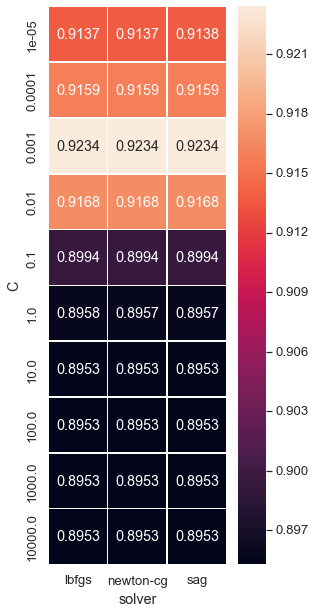

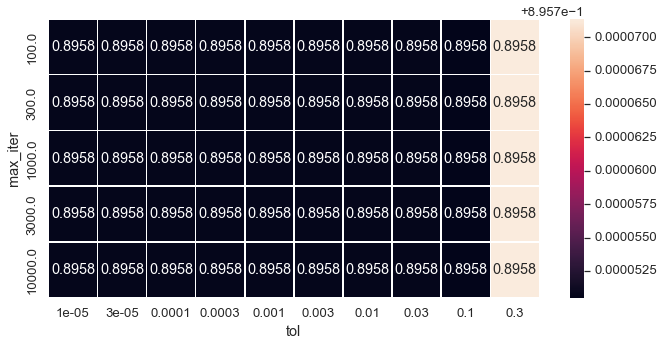

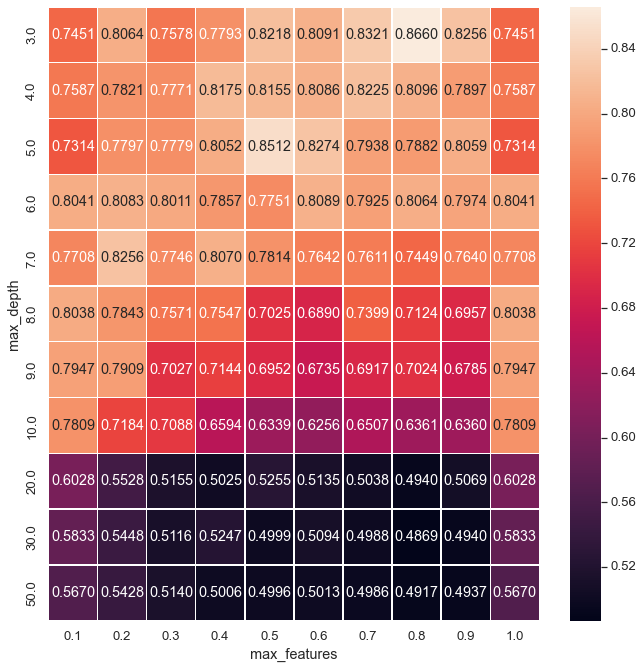

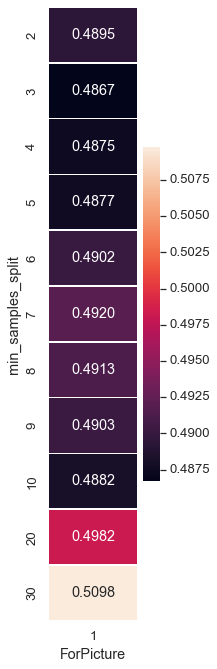

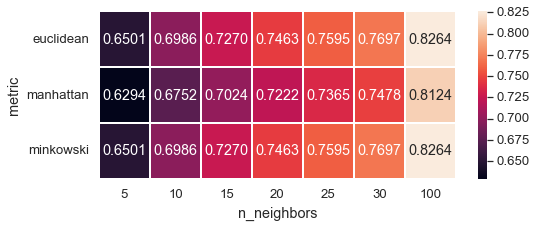

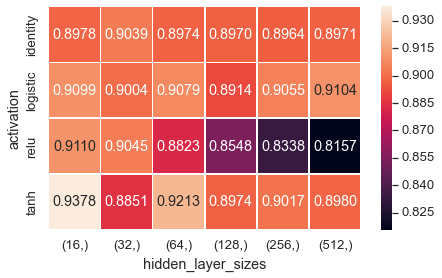

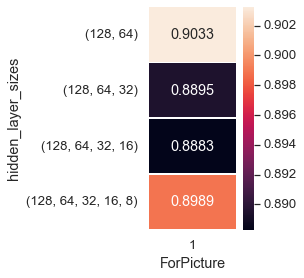

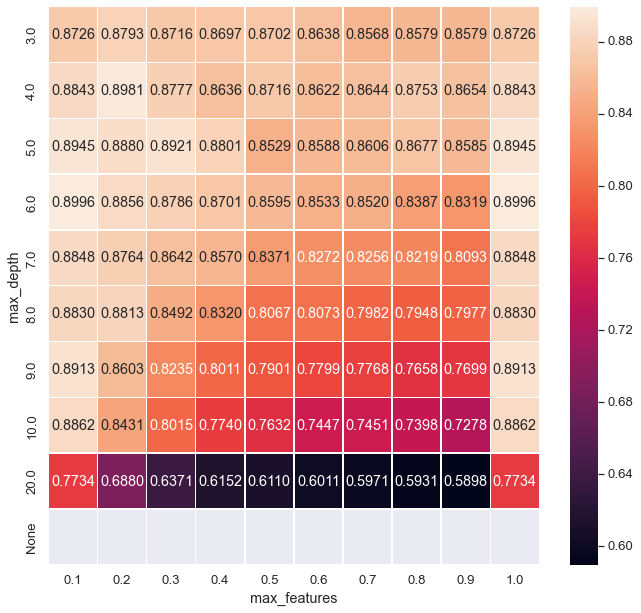

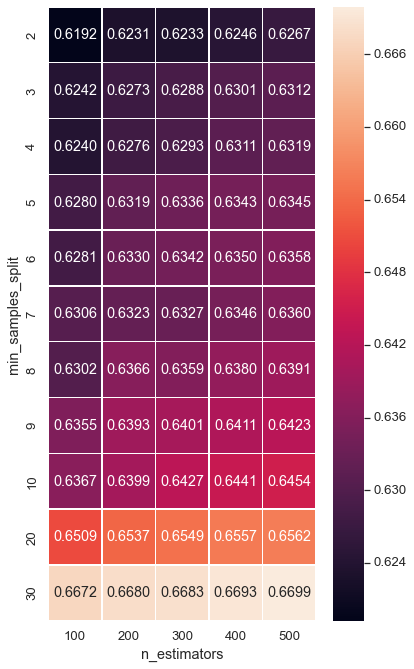

In [68]:
Filename = ['LR','DT','KNN','ANN','MLP','RF']

for i in range(len(tuning_result)):
    for j in range(len(tuning_result[i])):
        result = tuning_result[i][j]['params'].apply(pd.Series)   
        if len(result.columns) == 1 :
            result['ForPicture'] = 1
        result['score'] = tuning_result[i][j]['mean_test_score']
        
        X_axls_len = len(result[list(result.columns)[1]].unique())+1
        Y_axls_len = len(result[list(result.columns)[0]].unique())
            
        plt.figure(figsize=(X_axls_len,Y_axls_len))
        heatmapdata = result.pivot(index=list(result.columns)[0], columns=list(result.columns)[1], values=list(result.columns)[2])
        sns.set(font_scale=1.2)
        GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

        plt.savefig(Picture_result+'/'+Filename[i]+str(j)+'.png')    

In [70]:
def get_oof(clf, X_Train, y_Train, X_Test):
    oof_train = np.zeros((len(X_Train),))
    oof_test = np.zeros((len(X_Test),))
    oof_test_skf = np.empty((NFOLDS, len(X_Test)))
    X_Train.index = range(len(X_Train))
    y_Train.index = range(len(y_Train))
    for i, (train_index, test_index) in enumerate(KF.split(X_Train)):
        X_tr = X_Train.loc[train_index]
        y_tr = y_Train.loc[train_index]
        X_te = X_Train.loc[test_index]

        clf.fit(X_tr, y_tr)

        oof_train[test_index] = clf.predict_proba(X_te)[:,1]
        oof_test_skf[i, :] = clf.predict_proba(X_Test)[:,1]

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [81]:
LR_Para1 = {'penalty': 'l2',
            'random_state': 42,
            'verbose': 0,
            'n_jobs': 8,
            'C': 0.001,
            'solver': 'lbfgs',
            'max_iter': 100,
            'tol': 0.1}
DT_Para1 = {'criterion': 'gini',
             'splitter': 'best',
             'random_state': 42,
             'max_depth': 4,
             'max_features': 0.3,
             'min_samples_split': 2}
KNN_Para1 = {'weights': 'uniform', 
             'algorithm': 'auto', 
             'metric': 'minkowski', 
             'n_neighbors': 100}
ANN_Para1 =  {'solver': 'adam', 
              'learning_rate': 'adaptive', 
              'max_iter': 2000, 
              'batch_size': 200, 
              'early_stopping': True, 
              'activation': 'relu', 
              'hidden_layer_sizes': (32,)}
MLP_Para1 = {'solver': 'adam',
             'learning_rate': 'adaptive',
             'activation': 'tanh',
             'max_iter': 2000,
             'batch_size': 200,
             'early_stopping': True,
             'hidden_layer_sizes': (64, 32)}
RF_Para1 =  {'criterion': 'gini',
             'random_state': 42,
             'max_depth': 5,
             'min_samples_split': 2,
             'max_features': 0.1,
             'n_estimators': 100}



def get_models():
    LR_HLS_1 = LogisticRegression(**LR_Para1)
    DT_HLS_1 =DecisionTreeClassifier(**DT_Para1)
    KNN_HLS_1= KNeighborsClassifier(**KNN_Para1)
    ANN_HLS_1 = MLPClassifier(**ANN_Para1)
    MLP_HLS_1 = MLPClassifier(**MLP_Para1)
    RF_HLS_1 = RandomForestClassifier(**RF_Para1)
    
    models ={'LR_HLS': LR_HLS_1,
             'DT_HLS': DT_HLS_1,
             'KNN_HLS':KNN_HLS_1,
             'ANN_HLS':ANN_HLS_1,
             'MLP_HLS':MLP_HLS_1,
             'RF_HLS':RF_HLS_1,
            }
    
    return models

In [82]:
aucresult1 = []
final_models = get_models_tuning(initial_params)

X_Train = x_hlsp2
X_Test = x_hlsp1

y_Train =pd.DataFrame(y_hlsp2) 
y_Test = pd.DataFrame(y_hlsp1) 

Stacking_Train = pd.DataFrame(columns = final_models,index =X_Train.index)
Stacking_Test = pd.DataFrame(columns = final_models,index =X_Test.index)

for m in final_models:
    M1_oof_train, M1_oof_test = get_oof(final_models[m], X_Train, y_Train, X_Test)
    print(m,"Model K-Fold AUC Train score: %.4f  " % roc_auc_score(y_Train,pd.DataFrame(M1_oof_train,index=y_Train.index)),end='')
    print(m,"Model K-Fold AUC Test score: %.4f" % roc_auc_score(y_Test['A0'],pd.DataFrame(M1_oof_test,index=y_Test.index)))
    aucresult1.append(roc_auc_score(y_Test['A0'],pd.DataFrame(M1_oof_test,index=y_Test.index)))
    Stacking_Train[m] =  M1_oof_train.ravel()
    Stacking_Test[m] = M1_oof_test.ravel()

LR_HLS Model K-Fold AUC Train score: 0.8711  LR_HLS Model K-Fold AUC Test score: 0.8624
DT_HLS Model K-Fold AUC Train score: 0.8864  DT_HLS Model K-Fold AUC Test score: 0.8761
KNN_HLS Model K-Fold AUC Train score: 0.9402  KNN_HLS Model K-Fold AUC Test score: 0.9331
ANN_HLS Model K-Fold AUC Train score: 0.9041  ANN_HLS Model K-Fold AUC Test score: 0.9007
MLP_HLS Model K-Fold AUC Train score: 0.8893  MLP_HLS Model K-Fold AUC Test score: 0.8854
RF_HLS Model K-Fold AUC Train score: 0.9115  RF_HLS Model K-Fold AUC Test score: 0.9003


In [83]:
Stacking = LogisticRegression().fit(Stacking_Train,y_Train)
print('Bagging training AUC score: %.4f' % roc_auc_score(y_Train,Stacking_Train.mean(axis=1)),end='')
print("  test AUC score: %.4f" % roc_auc_score(y_Test['A0'],Stacking_Test.mean(axis=1)))
print("LR stacking training AUC score: %.4f" % roc_auc_score(y_Train,Stacking.predict_proba(Stacking_Train)[:,1]),end='')
print("  test AUC score: %.4f" % roc_auc_score(y_Test['A0'],Stacking.predict_proba(Stacking_Test)[:,1]))

Bagging training AUC score: 0.9195  test AUC score: 0.9096
LR stacking training AUC score: 0.9413  test AUC score: 0.9348


In [84]:
ModelResult = Stacking_Train.copy()
ModelResult['Bagging'] = Stacking_Train.mean(axis=1)
ModelResult['Stacking'] =Stacking.predict_proba(Stacking_Train)[:,1]

ModelResult2 = Stacking_Test.copy()
ModelResult2['Bagging'] = Stacking_Test.mean(axis=1)
ModelResult2['Stacking'] =Stacking.predict_proba(Stacking_Test)[:,1]

In [85]:
ModelResult2.index = All_dataPo1.index
ModelResult2['X'] = All_dataPo1['XCoord']
ModelResult2['Y'] = All_dataPo1['YCoord']
ModelResult2['HLS'] = All_dataPo1['A0']
ModelResult2['ELS'] = All_dataPo1['A1']

In [86]:
def plot_map_point(Data,Labelvalues,Labletext,ColorLabel,var='A1',titles='Susceptibility map'):
    
    plt.figure(figsize=(15,10))
    
    for i in range(len(Labelvalues)):
        temp = Data[Data[var]==Labelvalues[i]]
        plt.scatter(temp['X'],temp['Y'],marker='o',color =ColorLabel[i] ,label=Labletext[i],s=0.5)
    
    plt.xticks(np.linspace(141.5,142.5,7),
           ['141$^{deg}$30$^{min}$E','141$^{deg}$40$^{min}$E','141$^{deg}$50$^{min}$E',
            '142$^{deg}$00$^{min}$E','142$^{deg}$10$^{min}$E','142$^{deg}$20$^{min}$E','142$^{deg}$30$^{min}$E'],fontsize=12);
    plt.xlim(141.7,142.4)

    plt.ylim(42.5,43.0)
    plt.yticks(np.linspace(42.5,43.0,4),
           ['42$^{deg}$30$^{min}$N','42$^{deg}$40$^{min}$N','42$^{deg}$50$^{min}$N','43$^{deg}$00$^{min}$N'],fontsize=12);

    plt.legend(loc = 'lower right',fontsize=16);
    plt.title(titles+' susceptibility map',fontsize=16)
    plt.show()

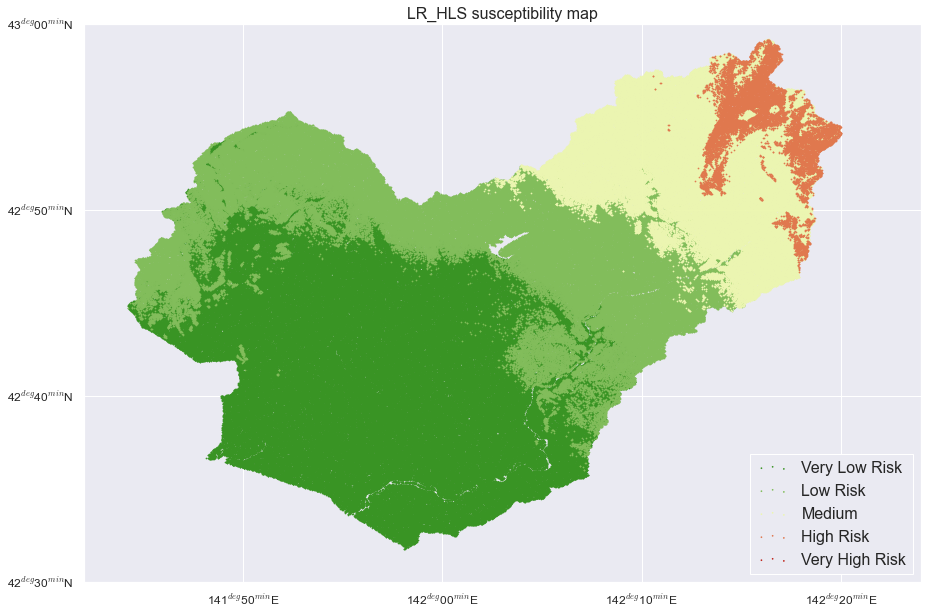

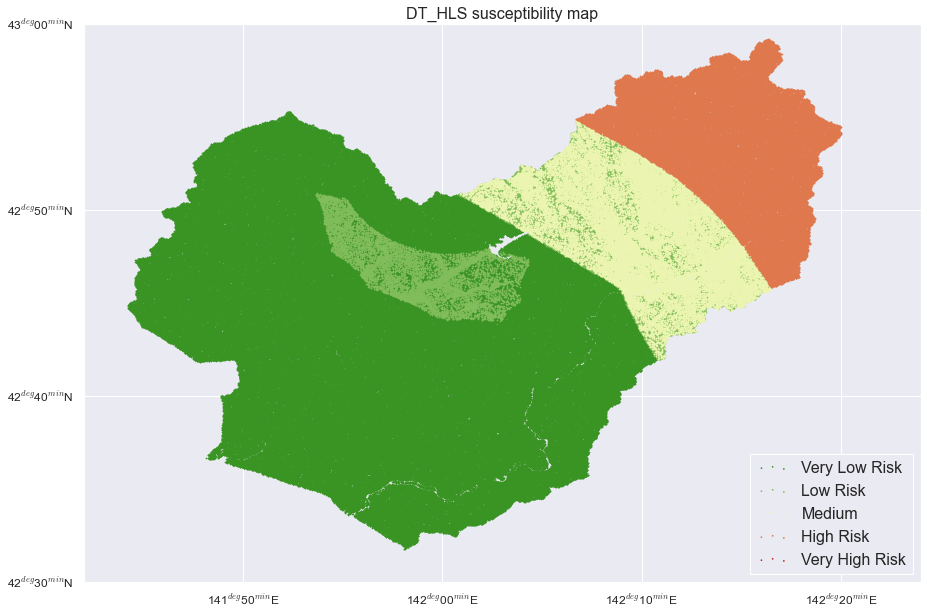

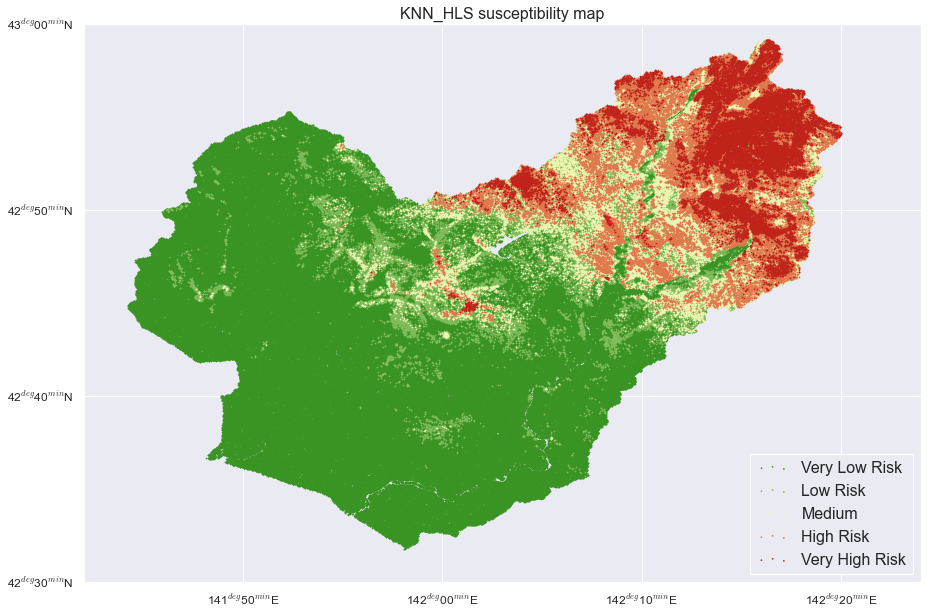

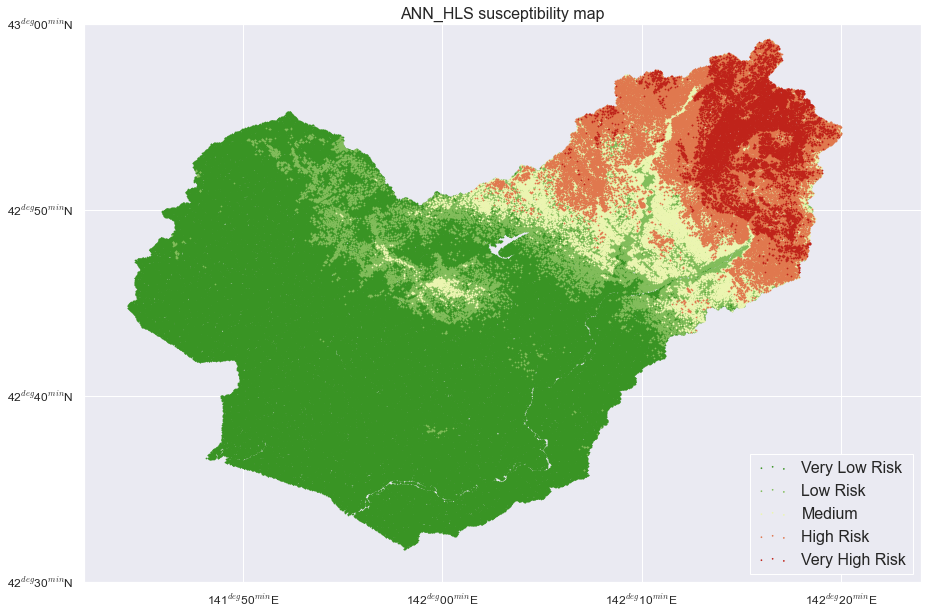

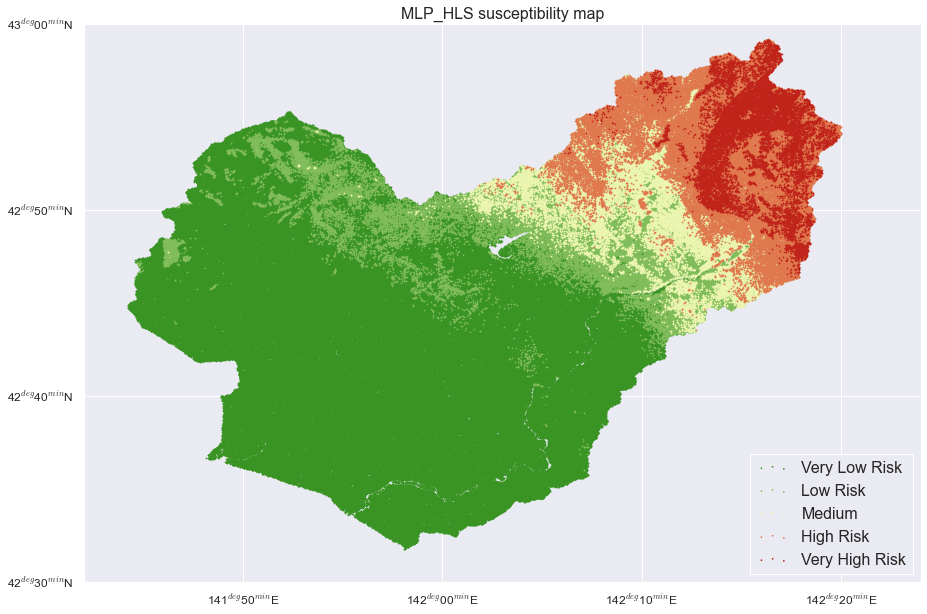

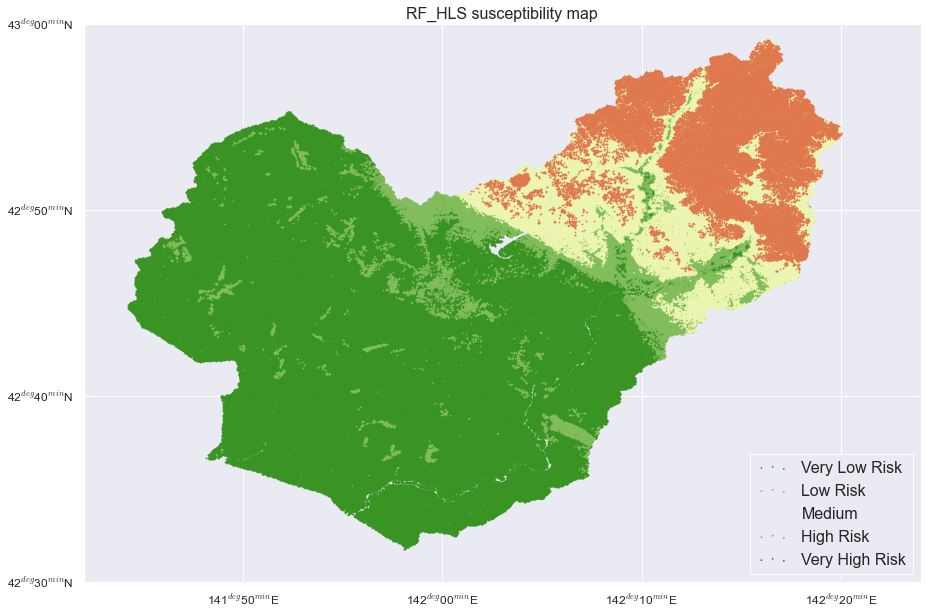

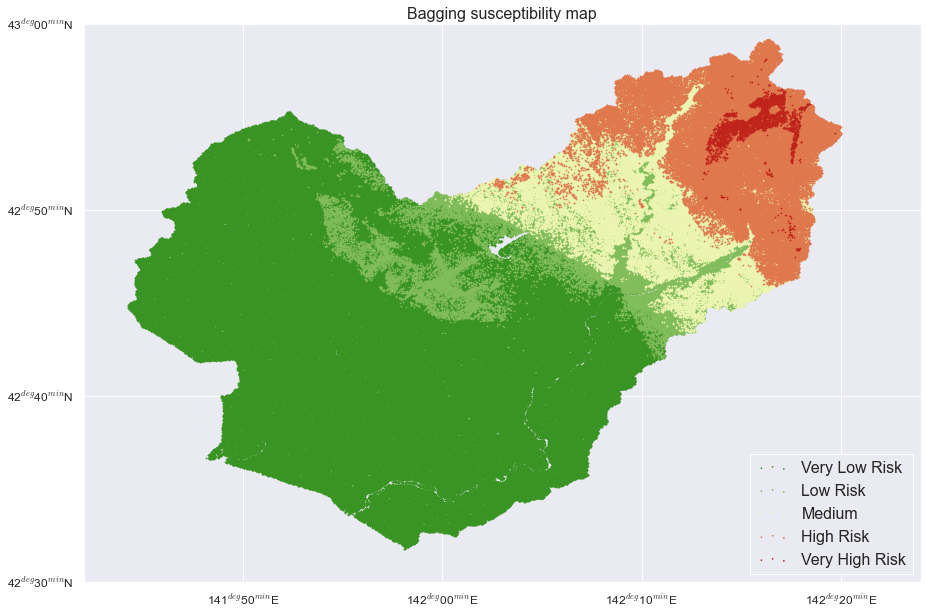

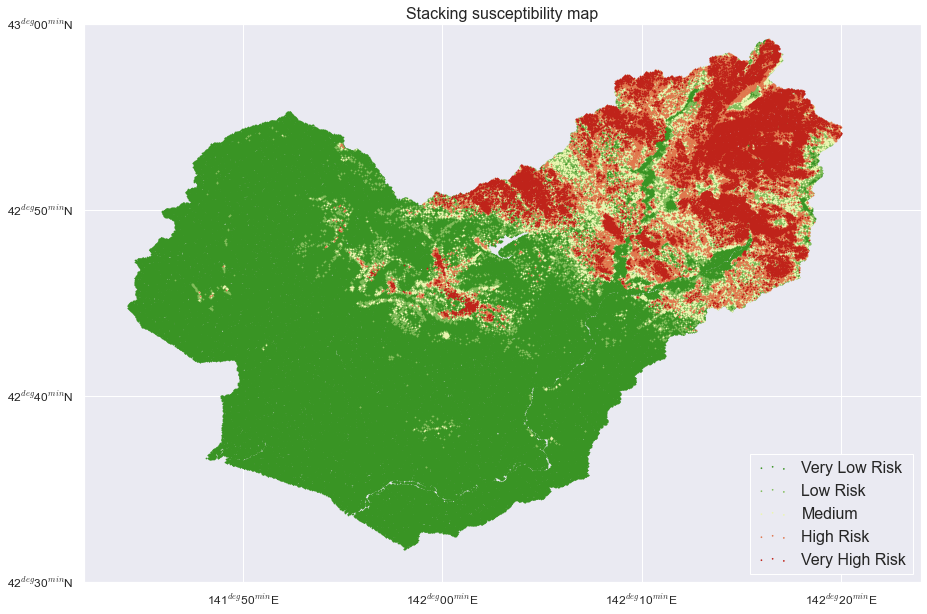

In [87]:
Labelvalues = ['Very Low Risk','Low Risk','Medium','High Risk','Very High Risk']
ColorLabel = ['#399424','#82BD5B','#ECF6B1','#E0784E','#BF231A']
bins = [-0.1,0.2,0.4,0.6,0.8,1.0]
TargetModel1 = ['LR_HLS','DT_HLS','KNN_HLS','ANN_HLS','MLP_HLS','RF_HLS','Bagging','Stacking']

for i in TargetModel1:
    ModelResult2['HLS_Risk'] = pd.cut(ModelResult2[i],bins,labels=['Very Low Risk','Low Risk',
                                                                      'Medium','High Risk','Very High Risk']) 

    plot_map_point(ModelResult2,Labelvalues,Labelvalues,ColorLabel,var='HLS_Risk',titles = i)

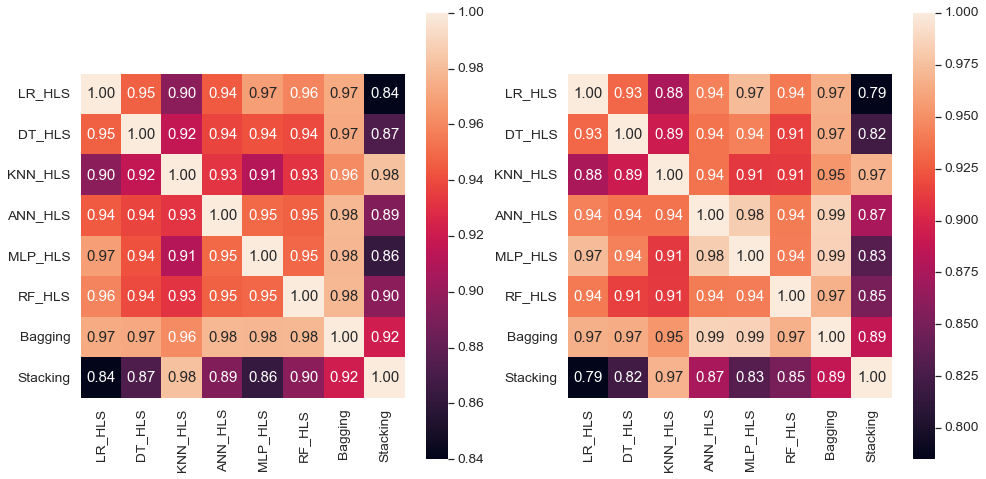

In [88]:
corrmat2= ModelResult.corr()
corrmat3= ModelResult2[list(ModelResult.columns)].corr()

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)

sns.set(font_scale=1.25)

hm = sns.heatmap(corrmat2,cbar=True,square=True,annot=True,fmt=".2f");
hm.set_ylim([corrmat2.shape[1], 0]);

plt.subplot(1,2,2)


sns.set(font_scale=1.25)

hm = sns.heatmap(corrmat3,cbar=True,square=True,annot=True,fmt=".2f");
hm.set_ylim([corrmat3.shape[1], 0]);

In [89]:
def plot_roc_curve(y_Test, P_learners, labels, title = 'Training dataset (Po2)'):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_learners.shape[1] + 1)]
    
    for i in range(P_learners.shape[1]):
        p = P_learners[:, i]
        fpr, tpr, _ = roc_curve(y_Test, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

        
    plt.xlabel('False positive rate',fontsize=14)
    plt.ylabel('True positive rate',fontsize=14)
    plt.title(title,fontsize=18)
    plt.legend(loc = 'lower right',title_fontsize=14,fontsize=14)
    plt.show()

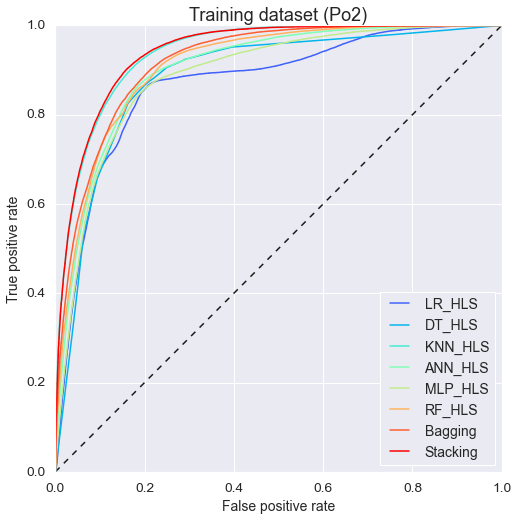

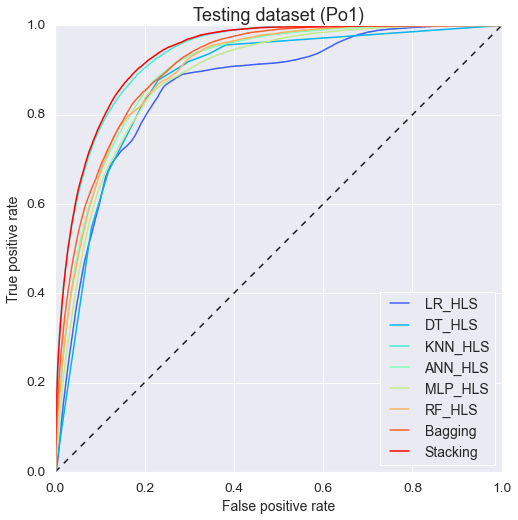

In [90]:
plot_roc_curve(y_Train, ModelResult.values, list(ModelResult.columns),title = 'Training dataset (Po2)')
plot_roc_curve(y_Test, ModelResult2[list(ModelResult.columns)].values, list(ModelResult.columns),title = 'Testing dataset (Po1)')